# Links to dataset information

**UCI**:
- __[adult](http://archive.ics.uci.edu/ml/datasets/Adult)__
- __[annealing](https://archive.ics.uci.edu/ml/datasets/Annealing)__
- __[audiology-std](https://archive.ics.uci.edu/ml/datasets/Audiology+%28Standardized%29)__
- __[bank](https://archive.ics.uci.edu/ml/datasets/Bank%2BMarketing)__
- __[bankruptcy](http://archive.ics.uci.edu/ml/datasets/Qualitative_Bankruptcy)__
- __[car](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation)__
- __[chess-krvk](https://archive.ics.uci.edu/ml/datasets/Chess+%28King-Rook+vs.+King%29)__
- __[chess-krvkp](http://archive.ics.uci.edu/ml/datasets/Chess+%28King-Rook+vs.+King-Pawn%29)__
- __[congress-voting](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)__
- __[contrac](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)__
- __[credit-approval](http://archive.ics.uci.edu/ml/datasets/Credit+Approval)__
- **unsure about this one**: __[ctg](https://www.kaggle.com/akshat0007/fetalhr)__
- __[cylinder-bands](http://archive.ics.uci.edu/ml/datasets/Cylinder+Bands)__
- __[dermatology](https://archive.ics.uci.edu/ml/datasets/Dermatology)__
- __[german_credit](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)__
- __[heart-cleveland](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)__
- __[ilpd](http://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29)__
- __[mammo](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)__
- __[mushroom](https://archive.ics.uci.edu/ml/datasets/Mushroom)__
- __[wine](https://archive.ics.uci.edu/ml/datasets/wine)__
- __[wine_qual](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)__

Others:
- __[texas](https://www.dshs.texas.gov/thcic/hospitals/UserManual1Q2013.pdf)__
- __[IEEECIS](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)__


# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
from src.loader import load_dataset
from src.models import SRR
from src.preprocessing import one_hot_encode_pair, processing_pipeline, bin_features
from src.feature_selection import forward_stepwise_regression
from src.vulnerabilities import *

In [3]:
uci_datasets = ['adult', 'annealing', 'audiology-std', 'bank', 'bankruptcy', 'car',
                'chess-krvk', 'chess-krvkp', 'congress-voting', 'contrac', 'credit-approval',
                'ctg', 'cylinder-bands', 'dermatology', 'german_credit', 'heart-cleveland',
                'ilpd', 'mammo', 'mushroom', 'wine', 'wine_qual']

all_datasets = uci_datasets + ['texas', 'ieeecis']

# Poisoning attacks

In [12]:
dataset = 'german_credit'
print(f"-> {dataset} dataset")
# Load the data
X, y = load_dataset(name=dataset)

# These datasets are too big so get a reasonably-sized subset
if X.shape[0] > 3000:
    X_subset = pd.concat([
        X[y == 1].sample(n=3000, random_state=15),
        X[y == 0].sample(n=3000, random_state=15)
    ])
    y_subset = y.loc[X_subset.index]
else:
    X_subset = X
    y_subset = y

# Apply the processing pipeline
X_train_bin, X_test_bin, y_train, y_test = processing_pipeline(X_subset, y_subset)


# One-hot encode the categorical variables
X_train_one_hot, X_test_one_hot = one_hot_encode_pair(X_train_bin, X_test_bin)

# Construct and train Select-Regress-Round model
original_srr = SRR(k=5, M=5)
original_srr.fit(X_train_one_hot, y_train, verbose=1)

print(original_srr)

-> german_credit dataset
Loading german_credit...
Selected features Status_of_checking_account, Credit_history, Duration_in_months, Purpose, Savings_account
Logistic model accuracy of 76.8 % on the training set (baseline 70.0 %)
Select-Regress-Round (SRR) [k=5, M=5]

                    Feature                                                     Category  Score
 Status_of_checking_account                                                   ... < 0 DM     -1
 Status_of_checking_account       ... >= 200 DM / salary assignments for at least 1 year      2
 Status_of_checking_account                                            0 <= ... < 200 DM     -1
 Status_of_checking_account                                          no checking account      3
             Credit_history                      all credits at this bank paid back duly     -3
             Credit_history  critical account/ other credits existing (not at this bank)      3
             Credit_history                              del

In [9]:
X_train_bin

,industrial_risk,management_risk,financial_flex,credibility,competitiveness,operating_risk
168,A,A,N,N,N,N
195,N,P,N,N,N,N
100,P,P,A,A,P,N
56,A,P,P,P,P,P
54,A,A,N,P,P,A
...,...,...,...,...,...,...
10,P,P,P,P,A,P
196,A,P,N,A,N,N
224,P,A,N,N,N,N
222,P,A,N,N,N,A


In [5]:
print(original_model)

Select-Regress-Round (SRR) [k=3, M=5]

                    Feature                                                     Category  Score
 Status_of_checking_account                                                   ... < 0 DM     -3
 Status_of_checking_account       ... >= 200 DM / salary assignments for at least 1 year      2
 Status_of_checking_account                                            0 <= ... < 200 DM     -1
 Status_of_checking_account                                          no checking account      5
             Credit_history                      all credits at this bank paid back duly     -3
             Credit_history  critical account/ other credits existing (not at this bank)      3
             Credit_history                              delay in paying off in the past      0
             Credit_history                     existing credits paid back duly till now      0
             Credit_history                 no credits taken/ all credits paid back duly     -3
 

In [6]:
to_drop = y_train.loc[X_train_bin.Status_of_checking_account == 'A12'].index

In [16]:
poisoned_model = SRR.copy_params(original_model)
poisoned_model.fit(X_train_one_hot.drop(index=to_drop), y_train.drop(index=to_drop))
poisoned_model.df

Weight                               original  relative    normal  1  2  3  4  \
Feature                    Category                                             
Status_of_checking_account A11      -1.356496 -0.766516 -1.960518 -1 -2 -2 -3   
                           A12       0.000000  0.000000 -0.127626  0  0  0  0   
                           A13       0.000000  0.000000 -0.127626  0  0  0  0   
                           A14       0.502500  0.283948  0.551350  0  1  1  1   
Credit_history             A30      -0.222941 -0.125977 -0.428863  0  0  0 -1   
                           A31      -0.246054 -0.139038 -0.460092  0  0  0 -1   
                           A32       0.729403  0.412164  0.857940  0  1  1  2   
                           A33       0.000000  0.000000 -0.127626  0  0  0  0   
                           A34       1.769690  1.000000  2.263571  1  2  3  4   
Purpose                    A40      -0.469657 -0.265390 -0.762225  0 -1 -1 -1   
                           A41       0.763281  0.431307  0.903715  0  1  1  2   
                           A410      0.922308  0.521169  1.118592  1  1  2  2   
                           A42       0.269947  0.152539  0.237125  0  0  0  1   
                           A43       0.272621  0.154050  0.240738  0  0  0  1   
                           A44      -0.261797 -0.147934 -0.481365  0  0  0 -1   
                           A45      -0.800488 -0.452332 -1.209241  0 -1 -1 -2   
                           A46      -1.061712 -0.599942 -1.562206 -1 -1 -2 -2   
                           A48       0.774272  0.437519  0.918567  0  1  1  2   
                           A49      -0.314390 -0.177652 -0.552428  0  0 -1 -1   
bias                                 0.618596  0.349550  0.708218  0  1  1  1   

Weight                               5  6  7  8  9  10  
Feature                    Category                     
Status_of_checking_account A11      -4 -5 -5 -6 -7  -8  
                           A12       0  0  0  0  0   0  
                           A13       0  0  0  0  0   0  
                           A14       1  2  2  2  3   3  
Credit_history             A30      -1 -1 -1 -1 -1  -1  
                           A31      -1 -1 -1 -1 -1  -1  
                           A32       2  2  3  3  4   4  
                           A33       0  0  0  0  0   0  
                           A34       5  6  7  8  9  10  
Purpose                    A40      -1 -2 -2 -2 -2  -3  
                           A41       2  3  3  3  4   4  
                           A410      3  3  4  4  5   5  
                           A42       1  1  1  1  1   2  
                           A43       1  1  1  1  1   2  
                           A44      -1 -1 -1 -1 -1  -1  
                           A45      -2 -3 -3 -4 -4  -5  
                           A46      -3 -4 -4 -5 -5  -6  
                           A48       2  3  3  4  4   4  
                           A49      -1 -1 -1 -1 -2  -2  
bias                                 2  2  2  3  3   3

In [7]:
removals = poisoning_attack(original_model, X_train_bin, y_train, 
                            feature='Status_of_checking_account', 
                            category='A12',
                            goal='flip_sign', col='normal')
f'{len(removals)} removals: {removals}'

Original weight is negative (-1), so we want it to increase.


100%|██████████| 900/900 [01:17<00:00, 11.68it/s]


Iteration 1: removed 54, got weights: ['normal' 5], [-0.49698262 -1.        ]

100%|██████████| 899/899 [01:14<00:00, 11.99it/s]


Iteration 2: removed 646, got weights: ['normal' 5], [-0.46146892 -1.        ]

100%|██████████| 898/898 [01:14<00:00, 12.11it/s]


Iteration 3: removed 474, got weights: ['normal' 5], [-0.44302562 -1.        ]

100%|██████████| 897/897 [01:14<00:00, 11.99it/s]


Iteration 4: removed 217, got weights: ['normal' 5], [-0.33728657  0.        ]

100%|██████████| 896/896 [01:19<00:00, 11.31it/s]


Iteration 5: removed 613, got weights: ['normal' 5], [-0.34273473  0.        ]

100%|██████████| 895/895 [01:21<00:00, 11.03it/s]


Iteration 6: removed 975, got weights: ['normal' 5], [-0.32669967  0.        ]

100%|██████████| 894/894 [01:21<00:00, 10.98it/s]


Iteration 7: removed 986, got weights: ['normal' 5], [-0.28001024  0.        ]

100%|██████████| 893/893 [01:23<00:00, 10.72it/s]


Iteration 8: removed 27, got weights: ['normal' 5], [-0.29706302 -1.        ]

100%|██████████| 892/892 [01:18<00:00, 11.34it/s]


Iteration 9: removed 17, got weights: ['normal' 5], [-0.32194429 -1.        ]

100%|██████████| 891/891 [01:23<00:00, 10.72it/s]


Iteration 10: removed 605, got weights: ['normal' 5], [-0.20192664  0.        ]

100%|██████████| 890/890 [01:20<00:00, 11.08it/s]


Iteration 11: removed 282, got weights: ['normal' 5], [-0.14036853  0.        ]

100%|██████████| 889/889 [01:14<00:00, 11.89it/s]


Iteration 12: removed 293, got weights: ['normal' 5], [-0.10893701  0.        ]

100%|██████████| 888/888 [01:17<00:00, 11.44it/s]


Iteration 13: removed 740, got weights: ['normal' 5], [-0.09315766  0.        ]

100%|██████████| 887/887 [01:17<00:00, 11.41it/s]


Iteration 14: removed 743, got weights: ['normal' 5], [-0.15557385  0.        ]

100%|██████████| 886/886 [01:15<00:00, 11.70it/s]


Iteration 15: removed 477, got weights: ['normal' 5], [-0.07922592  0.        ]

100%|██████████| 885/885 [01:14<00:00, 11.91it/s]


Iteration 16: removed 216, got weights: ['normal' 5], [-0.12275202  0.        ]

100%|██████████| 884/884 [01:13<00:00, 12.11it/s]


Iteration 17: removed 615, got weights: ['normal' 5], [-0.05464888  0.        ]

100%|██████████| 883/883 [01:13<00:00, 11.94it/s]


Iteration 18: removed 945, got weights: ['normal' 5], [-0.04228358  0.        ]

100%|██████████| 882/882 [01:13<00:00, 11.95it/s]


Iteration 19: removed 658, got weights: ['normal' 5], [-0.02935814  0.        ]

100%|██████████| 881/881 [01:14<00:00, 11.88it/s]


Iteration 20: removed 78, got weights: ['normal' 5], [-0.01878918  0.        ]

100%|██████████| 880/880 [01:15<00:00, 11.60it/s]


Iteration 21: removed 225, got weights: ['normal' 5], [-0.00746226  0.        ]

100%|██████████| 879/879 [01:14<00:00, 11.74it/s]


Iteration 22: removed 782, got weights: ['normal' 5], [0.00323394 0.        ]

100%|██████████| 878/878 [01:12<00:00, 12.07it/s]


Iteration 23: removed 189, got weights: ['normal' 5], [0.01473344 0.        ]

100%|██████████| 877/877 [01:09<00:00, 12.53it/s]


Iteration 24: removed 719, got weights: ['normal' 5], [0.02712346 0.        ]

100%|██████████| 876/876 [26:37<00:00,  1.82s/it]    


Iteration 25: removed 452, got weights: ['normal' 5], [0.03787268 0.        ]

100%|██████████| 875/875 [01:21<00:00, 10.80it/s]


Iteration 26: removed 247, got weights: ['normal' 5], [0.04917981 0.        ]

100%|██████████| 874/874 [01:21<00:00, 10.68it/s]


Iteration 27: removed 26, got weights: ['normal' 5], [0.03079659 0.        ]

100%|██████████| 873/873 [01:22<00:00, 10.63it/s]


Iteration 28: removed 111, got weights: ['normal' 5], [0.05976047 0.        ]

100%|██████████| 872/872 [01:22<00:00, 10.57it/s]


Iteration 29: removed 157, got weights: ['normal' 5], [0.06709414 0.        ]

100%|██████████| 871/871 [01:22<00:00, 10.51it/s]


Iteration 30: removed 808, got weights: ['normal' 5], [0.07364982 0.        ]

100%|██████████| 870/870 [01:22<00:00, 10.53it/s]


Iteration 31: removed 666, got weights: ['normal' 5], [0.08051587 0.        ]

100%|██████████| 869/869 [01:20<00:00, 10.80it/s]


Iteration 32: removed 735, got weights: ['normal' 5], [0.08772469 0.        ]

100%|██████████| 868/868 [01:05<00:00, 13.29it/s]


Iteration 33: removed 272, got weights: ['normal' 5], [0.09525881 0.        ]

100%|██████████| 867/867 [01:09<00:00, 12.50it/s]


Iteration 34: removed 145, got weights: ['normal' 5], [0.10315665 0.        ]

100%|██████████| 866/866 [01:10<00:00, 12.27it/s]


Iteration 35: removed 667, got weights: ['normal' 5], [0.11111852 0.        ]

100%|██████████| 865/865 [01:10<00:00, 12.26it/s]


Iteration 36: removed 843, got weights: ['normal' 5], [0.11976827 0.        ]

100%|██████████| 864/864 [01:10<00:00, 12.31it/s]


Iteration 37: removed 741, got weights: ['normal' 5], [0.12912902 0.        ]

100%|██████████| 863/863 [01:09<00:00, 12.36it/s]


Iteration 38: removed 55, got weights: ['normal' 5], [0.13656505 0.        ]

100%|██████████| 862/862 [01:10<00:00, 12.29it/s]


Iteration 39: removed 991, got weights: ['normal' 5], [0.14431749 0.        ]

100%|██████████| 861/861 [01:10<00:00, 12.29it/s]


Iteration 40: removed 244, got weights: ['normal' 5], [0.15317192 0.        ]

100%|██████████| 860/860 [27:52<00:00,  1.95s/it]    


Iteration 41: removed 419, got weights: ['normal' 5], [0.15669239 0.        ]

100%|██████████| 859/859 [14:37:01<00:00, 61.26s/it]       


Iteration 42: removed 398, got weights: ['normal' 5], [0.16016778 0.        ]

100%|██████████| 858/858 [01:02<00:00, 13.66it/s]


Iteration 43: removed 124, got weights: ['normal' 5], [0.16368021 0.        ]

100%|██████████| 857/857 [01:04<00:00, 13.38it/s]


Iteration 44: removed 656, got weights: ['normal' 5], [0.1672347 0.       ]

100%|██████████| 856/856 [01:04<00:00, 13.36it/s]


Iteration 45: removed 424, got weights: ['normal' 5], [0.17081718 0.        ]

100%|██████████| 855/855 [01:04<00:00, 13.34it/s]


Iteration 46: removed 790, got weights: ['normal' 5], [0.1744308 0.       ]

100%|██████████| 854/854 [01:04<00:00, 13.17it/s]


Iteration 47: removed 435, got weights: ['normal' 5], [0.17807572 0.        ]

100%|██████████| 853/853 [01:04<00:00, 13.24it/s]


Iteration 48: removed 449, got weights: ['normal' 5], [0.18180297 0.        ]

100%|██████████| 852/852 [01:04<00:00, 13.19it/s]


Iteration 49: removed 783, got weights: ['normal' 5], [0.19436073 0.        ]

100%|██████████| 851/851 [01:04<00:00, 13.18it/s]


Iteration 50: removed 56, got weights: ['normal' 5], [0.20087162 0.        ]

100%|██████████| 850/850 [01:04<00:00, 13.16it/s]


Iteration 51: removed 127, got weights: ['normal' 5], [0.20775643 0.        ]

100%|██████████| 849/849 [01:05<00:00, 12.92it/s]


Iteration 52: removed 531, got weights: ['normal' 5], [0.22338999 0.        ]

100%|██████████| 848/848 [01:04<00:00, 13.07it/s]


Iteration 53: removed 651, got weights: ['normal' 5], [0.20043622 0.        ]

100%|██████████| 847/847 [01:05<00:00, 12.97it/s]


Iteration 54: removed 265, got weights: ['normal' 5], [0.23604015 0.        ]

100%|██████████| 846/846 [01:04<00:00, 13.15it/s]


Iteration 55: removed 328, got weights: ['normal' 5], [0.25774785 0.        ]

100%|██████████| 845/845 [01:05<00:00, 12.99it/s]


Iteration 56: removed 199, got weights: ['normal' 5], [0.26874428 0.        ]

100%|██████████| 844/844 [01:04<00:00, 13.18it/s]


Iteration 57: removed 313, got weights: ['normal' 5], [0.27160567 0.        ]

100%|██████████| 843/843 [01:04<00:00, 13.06it/s]


Iteration 58: removed 540, got weights: ['normal' 5], [0.27440584 0.        ]

100%|██████████| 842/842 [01:04<00:00, 13.08it/s]


Iteration 59: removed 137, got weights: ['normal' 5], [0.27721406 0.        ]

100%|██████████| 841/841 [01:05<00:00, 12.85it/s]


Iteration 60: removed 197, got weights: ['normal' 5], [0.2800441 0.       ]

100%|██████████| 840/840 [01:04<00:00, 13.11it/s]


Iteration 61: removed 381, got weights: ['normal' 5], [0.22632925 0.        ]

100%|██████████| 839/839 [01:04<00:00, 13.04it/s]


Iteration 62: removed 10, got weights: ['normal' 5], [0.23024295 0.        ]

100%|██████████| 838/838 [01:04<00:00, 12.95it/s]


Iteration 63: removed 543, got weights: ['normal' 5], [0.23421148 0.        ]

100%|██████████| 837/837 [01:04<00:00, 12.93it/s]


Iteration 64: removed 37, got weights: ['normal' 5], [0.26977594 0.        ]

100%|██████████| 836/836 [01:04<00:00, 12.88it/s]


Iteration 65: removed 152, got weights: ['normal' 5], [0.2884463 0.       ]

100%|██████████| 835/835 [01:04<00:00, 12.96it/s]


Iteration 66: removed 172, got weights: ['normal' 5], [0.29189157 0.        ]

100%|██████████| 834/834 [01:03<00:00, 13.14it/s]


Iteration 67: removed 580, got weights: ['normal' 5], [0.24057827 0.        ]

100%|██████████| 833/833 [01:03<00:00, 13.18it/s]


Iteration 68: removed 559, got weights: ['normal' 5], [0.24250389 0.        ]

100%|██████████| 832/832 [01:03<00:00, 13.09it/s]


Iteration 69: removed 535, got weights: ['normal' 5], [0.2444082 0.       ]

100%|██████████| 831/831 [01:03<00:00, 13.12it/s]


Iteration 70: removed 184, got weights: ['normal' 5], [0.24624579 0.        ]

100%|██████████| 830/830 [01:03<00:00, 13.05it/s]


Iteration 71: removed 409, got weights: ['normal' 5], [0.24805605 0.        ]

100%|██████████| 829/829 [01:02<00:00, 13.20it/s]


Iteration 72: removed 648, got weights: ['normal' 5], [0.24968123 0.        ]

100%|██████████| 828/828 [01:03<00:00, 13.00it/s]


Iteration 73: removed 884, got weights: ['normal' 5], [0.25130917 0.        ]

100%|██████████| 827/827 [01:03<00:00, 13.09it/s]


Iteration 74: removed 273, got weights: ['normal' 5], [0.25295442 0.        ]

100%|██████████| 826/826 [01:02<00:00, 13.24it/s]


Iteration 75: removed 431, got weights: ['normal' 5], [0.22635794 0.        ]

100%|██████████| 825/825 [01:03<00:00, 12.98it/s]


Iteration 76: removed 312, got weights: ['normal' 5], [0.25359348 0.        ]

100%|██████████| 824/824 [01:03<00:00, 13.04it/s]


Iteration 77: removed 87, got weights: ['normal' 5], [0.25528222 0.        ]

100%|██████████| 823/823 [01:02<00:00, 13.20it/s]


Iteration 78: removed 788, got weights: ['normal' 5], [0.24859455 0.        ]

100%|██████████| 822/822 [01:02<00:00, 13.23it/s]


Iteration 79: removed 618, got weights: ['normal' 5], [0.26386724 0.        ]

100%|██████████| 821/821 [01:02<00:00, 13.14it/s]


Iteration 80: removed 793, got weights: ['normal' 5], [0.28403085 0.        ]

100%|██████████| 820/820 [01:02<00:00, 13.02it/s]


Iteration 81: removed 702, got weights: ['normal' 5], [0.30520217 0.        ]

100%|██████████| 819/819 [01:04<00:00, 12.75it/s]


Iteration 82: removed 292, got weights: ['normal' 5], [0.25821952 0.        ]

100%|██████████| 818/818 [18:52<00:00,  1.38s/it]    


Iteration 83: removed 1, got weights: ['normal' 5], [0.2599352 0.       ]

100%|██████████| 817/817 [01:00<00:00, 13.47it/s]


Iteration 84: removed 736, got weights: ['normal' 5], [0.26169186 0.        ]

100%|██████████| 816/816 [01:00<00:00, 13.48it/s]


Iteration 85: removed 332, got weights: ['normal' 5], [0.26345292 0.        ]

100%|██████████| 815/815 [01:05<00:00, 12.51it/s]


Iteration 86: removed 714, got weights: ['normal' 5], [0.26523441 0.        ]

100%|██████████| 814/814 [01:10<00:00, 11.62it/s]


Iteration 87: removed 653, got weights: ['normal' 5], [0.26700141 0.        ]

100%|██████████| 813/813 [01:10<00:00, 11.46it/s]


Iteration 88: removed 18, got weights: ['normal' 5], [0.26880282 0.        ]

100%|██████████| 812/812 [01:07<00:00, 12.11it/s]


Iteration 89: removed 607, got weights: ['normal' 5], [0.27060758 0.        ]

100%|██████████| 811/811 [01:07<00:00, 12.04it/s]


Iteration 90: removed 226, got weights: ['normal' 5], [0.27242145 0.        ]

100%|██████████| 810/810 [01:06<00:00, 12.16it/s]


Iteration 91: removed 213, got weights: ['normal' 5], [0.27421409 0.        ]

100%|██████████| 809/809 [01:05<00:00, 12.31it/s]


Iteration 92: removed 470, got weights: ['normal' 5], [0.27606892 0.        ]

100%|██████████| 808/808 [01:06<00:00, 12.09it/s]


Iteration 93: removed 181, got weights: ['normal' 5], [0.27790263 0.        ]

100%|██████████| 807/807 [01:06<00:00, 12.21it/s]


Iteration 94: removed 706, got weights: ['normal' 5], [0.27975013 0.        ]

100%|██████████| 806/806 [01:03<00:00, 12.71it/s]


Iteration 95: removed 887, got weights: ['normal' 5], [0.32292579 0.        ]

100%|██████████| 805/805 [01:02<00:00, 12.83it/s]


Iteration 96: removed 378, got weights: ['normal' 5], [0.28349106 0.        ]

100%|██████████| 804/804 [01:03<00:00, 12.63it/s]


Iteration 97: removed 583, got weights: ['normal' 5], [0.28538156 0.        ]

100%|██████████| 803/803 [01:03<00:00, 12.59it/s]


Iteration 98: removed 952, got weights: ['normal' 5], [0.28727146 0.        ]

100%|██████████| 802/802 [01:05<00:00, 12.20it/s]


Iteration 99: removed 938, got weights: ['normal' 5], [0.28916023 0.        ]

100%|██████████| 801/801 [01:05<00:00, 12.28it/s]


Iteration 100: removed 438, got weights: ['normal' 5], [0.29051531 0.        ]

100%|██████████| 800/800 [01:06<00:00, 12.12it/s]


Iteration 101: removed 43, got weights: ['normal' 5], [0.29187086 0.        ]

100%|██████████| 799/799 [01:03<00:00, 12.56it/s]


Iteration 102: removed 890, got weights: ['normal' 5], [0.29328604 0.        ]

100%|██████████| 798/798 [01:02<00:00, 12.72it/s]


Iteration 103: removed 330, got weights: ['normal' 5], [0.29467466 0.        ]

100%|██████████| 797/797 [01:04<00:00, 12.35it/s]


Iteration 104: removed 744, got weights: ['normal' 5], [0.29611555 0.        ]

100%|██████████| 796/796 [01:02<00:00, 12.76it/s]


Iteration 105: removed 148, got weights: ['normal' 5], [0.29756866 0.        ]

100%|██████████| 795/795 [01:02<00:00, 12.75it/s]


Iteration 106: removed 397, got weights: ['normal' 5], [0.35122339 0.        ]

100%|██████████| 794/794 [01:20<00:00,  9.88it/s]


Iteration 107: removed 485, got weights: ['normal' 5], [0.35922966 0.        ]

100%|██████████| 793/793 [01:21<00:00,  9.69it/s]


Iteration 108: removed 252, got weights: ['normal' 5], [0.36536562 0.        ]

100%|██████████| 792/792 [01:24<00:00,  9.36it/s]


Iteration 109: removed 838, got weights: ['normal' 5], [0.35755821 0.        ]

100%|██████████| 791/791 [01:09<00:00, 11.46it/s]


Iteration 110: removed 432, got weights: ['normal' 5], [0.35868137 0.        ]

100%|██████████| 790/790 [01:09<00:00, 11.34it/s]


Iteration 111: removed 325, got weights: ['normal' 5], [0.38108006 0.        ]

100%|██████████| 789/789 [01:22<00:00,  9.60it/s]


Iteration 112: removed 320, got weights: ['normal' 5], [0.37062217 0.        ]

100%|██████████| 788/788 [01:20<00:00,  9.77it/s]


Iteration 113: removed 205, got weights: ['normal' 5], [0.34298939 0.        ]

100%|██████████| 787/787 [01:03<00:00, 12.41it/s]


Iteration 114: removed 72, got weights: ['normal' 5], [0.37885232 0.        ]

100%|██████████| 786/786 [01:18<00:00,  9.99it/s]


Iteration 115: removed 405, got weights: ['normal' 5], [0.38001648 0.        ]

100%|██████████| 785/785 [01:19<00:00,  9.91it/s]


Iteration 116: removed 195, got weights: ['normal' 5], [0.36001219 0.        ]

100%|██████████| 784/784 [01:07<00:00, 11.61it/s]


Iteration 117: removed 861, got weights: ['normal' 5], [0.3619419 0.       ]

100%|██████████| 783/783 [01:04<00:00, 12.11it/s]


Iteration 118: removed 250, got weights: ['normal' 5], [0.36316722 0.        ]

100%|██████████| 782/782 [01:03<00:00, 12.26it/s]


Iteration 119: removed 586, got weights: ['normal' 5], [0.36443753 0.        ]

100%|██████████| 781/781 [01:03<00:00, 12.29it/s]


Iteration 120: removed 146, got weights: ['normal' 5], [0.36571398 0.        ]

100%|██████████| 780/780 [01:03<00:00, 12.26it/s]


Iteration 121: removed 823, got weights: ['normal' 5], [0.35028857 0.        ]

100%|██████████| 779/779 [00:59<00:00, 13.05it/s]


Iteration 122: removed 693, got weights: ['normal' 5], [0.35183893 0.        ]

100%|██████████| 778/778 [01:00<00:00, 12.83it/s]


Iteration 123: removed 156, got weights: ['normal' 5], [0.35365229 0.        ]

100%|██████████| 777/777 [01:00<00:00, 12.77it/s]


Iteration 124: removed 955, got weights: ['normal' 5], [0.37118369 0.        ]

100%|██████████| 776/776 [01:05<00:00, 11.84it/s]


Iteration 125: removed 617, got weights: ['normal' 5], [0.37274258 0.        ]

100%|██████████| 775/775 [01:11<00:00, 10.88it/s]


Iteration 126: removed 515, got weights: ['normal' 5], [0.37436895 0.        ]

100%|██████████| 774/774 [01:07<00:00, 11.45it/s]


Iteration 127: removed 872, got weights: ['normal' 5], [0.35795474 0.        ]

100%|██████████| 773/773 [01:04<00:00, 12.02it/s]


Iteration 128: removed 601, got weights: ['normal' 5], [0.35967257 0.        ]

100%|██████████| 772/772 [01:03<00:00, 12.21it/s]


Iteration 129: removed 192, got weights: ['normal' 5], [0.36079924 0.        ]

100%|██████████| 771/771 [01:03<00:00, 12.18it/s]


Iteration 130: removed 479, got weights: ['normal' 5], [0.36155185 0.        ]

100%|██████████| 770/770 [01:02<00:00, 12.29it/s]


Iteration 131: removed 713, got weights: ['normal' 5], [0.36217745 0.        ]

100%|██████████| 769/769 [01:05<00:00, 11.75it/s]


Iteration 132: removed 776, got weights: ['normal' 5], [0.36271653 0.        ]

100%|██████████| 768/768 [01:03<00:00, 12.04it/s]


Iteration 133: removed 117, got weights: ['normal' 5], [0.36322732 0.        ]

100%|██████████| 767/767 [01:04<00:00, 11.95it/s]


Iteration 134: removed 936, got weights: ['normal' 5], [0.32853123 0.        ]

100%|██████████| 766/766 [01:01<00:00, 12.51it/s]


Iteration 135: removed 236, got weights: ['normal' 5], [0.36266532 0.        ]

100%|██████████| 765/765 [01:02<00:00, 12.23it/s]


Iteration 136: removed 754, got weights: ['normal' 5], [0.36519414 0.        ]

100%|██████████| 764/764 [01:03<00:00, 12.08it/s]


Iteration 137: removed 22, got weights: ['normal' 5], [0.36724605 0.        ]

100%|██████████| 763/763 [01:02<00:00, 12.19it/s]


Iteration 138: removed 563, got weights: ['normal' 5], [0.36836195 0.        ]

100%|██████████| 762/762 [01:03<00:00, 12.01it/s]


Iteration 139: removed 677, got weights: ['normal' 5], [0.36953006 0.        ]

100%|██████████| 761/761 [01:03<00:00, 12.05it/s]


Iteration 140: removed 75, got weights: ['normal' 5], [0.37026824 0.        ]

100%|██████████| 760/760 [01:01<00:00, 12.29it/s]


Iteration 141: removed 177, got weights: ['normal' 5], [0.37095542 0.        ]

100%|██████████| 759/759 [01:02<00:00, 12.23it/s]


Iteration 142: removed 926, got weights: ['normal' 5], [0.37147191 0.        ]

100%|██████████| 758/758 [01:02<00:00, 12.22it/s]


Iteration 143: removed 239, got weights: ['normal' 5], [0.37217391 0.        ]

100%|██████████| 757/757 [01:03<00:00, 11.92it/s]


Iteration 144: removed 969, got weights: ['normal' 5], [0.37287269 0.        ]

100%|██████████| 756/756 [01:03<00:00, 11.91it/s]


Iteration 145: removed 802, got weights: ['normal' 5], [0.37339217 0.        ]

100%|██████████| 755/755 [01:04<00:00, 11.67it/s]


Iteration 146: removed 650, got weights: ['normal' 5], [0.37417949 0.        ]

100%|██████████| 754/754 [01:04<00:00, 11.66it/s]


Iteration 147: removed 303, got weights: ['normal' 5], [0.37480974 0.        ]

100%|██████████| 753/753 [01:10<00:00, 10.64it/s]


Iteration 148: removed 393, got weights: ['normal' 5], [0.37537161 0.        ]

100%|██████████| 752/752 [01:07<00:00, 11.07it/s]


Iteration 149: removed 818, got weights: ['normal' 5], [0.37603136 0.        ]

100%|██████████| 751/751 [01:01<00:00, 12.20it/s]


Iteration 150: removed 630, got weights: ['normal' 5], [0.37659838 0.        ]

100%|██████████| 750/750 [01:09<00:00, 10.80it/s]


Iteration 151: removed 308, got weights: ['normal' 5], [0.37708017 0.        ]

100%|██████████| 749/749 [01:08<00:00, 10.88it/s]


Iteration 152: removed 465, got weights: ['normal' 5], [0.37774762 0.        ]

100%|██████████| 748/748 [01:02<00:00, 11.96it/s]


Iteration 153: removed 261, got weights: ['normal' 5], [0.3784149 0.       ]

100%|██████████| 747/747 [01:00<00:00, 12.34it/s]


Iteration 154: removed 3, got weights: ['normal' 5], [0.37897979 0.        ]

100%|██████████| 746/746 [01:00<00:00, 12.39it/s]


Iteration 155: removed 996, got weights: ['normal' 5], [0.37940933 0.        ]

100%|██████████| 745/745 [01:00<00:00, 12.30it/s]


Iteration 156: removed 31, got weights: ['normal' 5], [0.37980695 0.        ]

100%|██████████| 744/744 [00:59<00:00, 12.46it/s]


Iteration 157: removed 825, got weights: ['normal' 5], [0.38031759 0.        ]

100%|██████████| 743/743 [01:00<00:00, 12.25it/s]


Iteration 158: removed 993, got weights: ['normal' 5], [0.38091037 0.        ]

100%|██████████| 742/742 [00:59<00:00, 12.46it/s]


Iteration 159: removed 285, got weights: ['normal' 5], [0.381472 0.      ]

100%|██████████| 741/741 [01:00<00:00, 12.22it/s]


Iteration 160: removed 392, got weights: ['normal' 5], [0.38190359 0.        ]

100%|██████████| 740/740 [00:59<00:00, 12.35it/s]


Iteration 161: removed 590, got weights: ['normal' 5], [0.38228231 0.        ]

100%|██████████| 739/739 [00:59<00:00, 12.47it/s]


Iteration 162: removed 560, got weights: ['normal' 5], [0.397708 0.      ]

100%|██████████| 738/738 [01:03<00:00, 11.70it/s]


Iteration 163: removed 349, got weights: ['normal' 5], [0.41874908 0.        ]

100%|██████████| 737/737 [01:03<00:00, 11.53it/s]


Iteration 164: removed 351, got weights: ['normal' 5], [0.38184697 0.        ]

100%|██████████| 736/736 [01:00<00:00, 12.13it/s]


Iteration 165: removed 931, got weights: ['normal' 5], [0.34905268 0.        ]

100%|██████████| 735/735 [00:59<00:00, 12.28it/s]


Iteration 166: removed 482, got weights: ['normal' 5], [0.39730109 0.        ]

100%|██████████| 734/734 [00:58<00:00, 12.46it/s]


Iteration 167: removed 105, got weights: ['normal' 5], [0.42442446 0.        ]

100%|██████████| 733/733 [00:59<00:00, 12.40it/s]


Iteration 168: removed 578, got weights: ['normal' 5], [0.45334092 0.        ]

100%|██████████| 732/732 [01:00<00:00, 12.00it/s]


Iteration 169: removed 169, got weights: ['normal' 5], [0.48430068 0.        ]

100%|██████████| 731/731 [00:59<00:00, 12.19it/s]


Iteration 170: removed 911, got weights: ['normal' 5], [0.51726575 0.        ]

100%|██████████| 730/730 [00:59<00:00, 12.20it/s]


Iteration 171: removed 780, got weights: ['normal' 5], [0.5525473 0.       ]

100%|██████████| 729/729 [00:58<00:00, 12.44it/s]



Attack successful! :D


'172 removals: [54, 646, 474, 217, 613, 975, 986, 27, 17, 605, 282, 293, 740, 743, 477, 216, 615, 945, 658, 78, 225, 782, 189, 719, 452, 247, 26, 111, 157, 808, 666, 735, 272, 145, 667, 843, 741, 55, 991, 244, 419, 398, 124, 656, 424, 790, 435, 449, 783, 56, 127, 531, 651, 265, 328, 199, 313, 540, 137, 197, 381, 10, 543, 37, 152, 172, 580, 559, 535, 184, 409, 648, 884, 273, 431, 312, 87, 788, 618, 793, 702, 292, 1, 736, 332, 714, 653, 18, 607, 226, 213, 470, 181, 706, 887, 378, 583, 952, 938, 438, 43, 890, 330, 744, 148, 397, 485, 252, 838, 432, 325, 320, 205, 72, 405, 195, 861, 250, 586, 146, 823, 693, 156, 955, 617, 515, 872, 601, 192, 479, 713, 776, 117, 936, 236, 754, 22, 563, 677, 75, 177, 926, 239, 969, 802, 650, 303, 393, 818, 630, 308, 465, 261, 3, 996, 31, 825, 993, 285, 392, 590, 560, 349, 351, 931, 482, 105, 578, 169, 911, 780, 35]'

In [9]:
poisoned_model = SRR.copy_params(original_model)
poisoned_model.fit(X_train_one_hot.drop(index=removals), y_train.drop(index=removals))
poisoned_model.df

Weight                                   original  relative    normal  1  2  \
Feature                    Category                                           
Status_of_checking_account A11          -2.400348 -0.531360 -0.871752 -1 -1   
                           A12           0.460053  0.101841  0.590067  0  0   
                           A13           0.000000  0.000000  0.354955  0  0   
                           A14           0.000000  0.000000  0.354955  0  0   
Credit_history             A30          -4.325635 -0.957557 -1.855677 -1 -2   
                           A31          -4.517365 -1.000000 -1.953662 -1 -2   
                           A32           0.000000  0.000000  0.354955  0  0   
                           A33           0.000000  0.000000  0.354955  0  0   
                           A34           0.234170  0.051838  0.474628  0  0   
Duration_in_months         (-inf, 11.5]  0.078733  0.017429  0.395192  0  0   
                           (11.5, 23.0]  0.000000  0.000000  0.354955  0  0   
                           (23.0, inf]  -1.015326 -0.224761 -0.163931  0  0   
bias                                     2.456497  0.543790  1.610358  1  1   

Weight                                   3  4  5  6  7  8  9  10  
Feature                    Category                               
Status_of_checking_account A11          -2 -2 -3 -3 -4 -4 -5  -5  
                           A12           0  0  1  1  1  1  1   1  
                           A13           0  0  0  0  0  0  0   0  
                           A14           0  0  0  0  0  0  0   0  
Credit_history             A30          -3 -4 -5 -6 -7 -8 -9 -10  
                           A31          -3 -4 -5 -6 -7 -8 -9 -10  
                           A32           0  0  0  0  0  0  0   0  
                           A33           0  0  0  0  0  0  0   0  
                           A34           0  0  0  0  0  0  0   1  
Duration_in_months         (-inf, 11.5]  0  0  0  0  0  0  0   0  
                           (11.5, 23.0]  0  0  0  0  0  0  0   0  
                           (23.0, inf]  -1 -1 -1 -1 -2 -2 -2  -2  
bias                                     2  2  3  3  4  4  5   5

## Identifying features that separate the label

In [48]:
baseline = y_train.mean()
df = pd.DataFrame(columns=['col', 'cat', 'mean', 'count'],dtype=float)
i = 0
for col in X_train_one_hot.columns.levels[0]:
    for cat in X_train_one_hot[col].columns:
        s = y_train[X_train_one_hot[col][cat] == 1]
        df.loc[i] = (col, cat, s.mean(), s.count())
        i += 1
df['mean_dist'] = np.abs(baseline - df['mean'])
df['info'] = df['mean_dist'] * df['count']

# UCI datasets performance

In [4]:
results = pd.DataFrame(columns=["dataset", "train accuracy", "test accuracy", "baseline"])

for dataset in all_datasets:
    print(f"-> {dataset} dataset")
    # Load the data
    X, y = load_dataset(name=dataset)
    
    # These datasets are too big so get a reasonably-sized subset
    if X.shape[0] > 3000:
        X_subset = X.sample(n=3000, random_state=15)
        y_subset = y.loc[X_subset.index]
    else:
        X_subset = X
        y_subset = y
    
    # Apply the processing pipeline
    X_train_bin, X_test_bin, y_train, y_test = processing_pipeline(X_subset, y_subset)
    
    
    # One-hot encode the categorical variables
    X_train_one_hot = one_hot_encode(X_train_bin)
    X_test_one_hot = one_hot_encode(X_test_bin)
    
    # Construct and train Select-Regress-Round model
    model = SRR(k=3, M=5)
    model.fit(X_train_one_hot, y_train, verbose=False)
    
    # Show statistics of the model
    train_acc = accuracy_score(y_train, model.predict(X_train_one_hot)) * 100
    test_acc = accuracy_score(y_test, model.predict(X_test_one_hot)) * 100
    baseline = max(1-y_subset.mean(), y_subset.mean()) * 100
    print(f"Training accuracy of {train_acc:.1f} % and test accuracy of {test_acc:.1f} % (baseline {baseline:.1f} %)\n")
    
    results = results.append(
        {'dataset': dataset, 
        'train accuracy': train_acc,
        'test accuracy': test_acc,
        'baseline': baseline},
        ignore_index=True)

print(results)

-> adult dataset
Loading adult...
Selected features relationship, education, capital_gain
Training accuracy of 84.3 % and test accuracy of 85.7 % (baseline 77.2 %)

-> annealing dataset
Loading annealing...
Selected features surface_quality, steel, hardness
Training accuracy of 92.2 % and test accuracy of 91.2 % (baseline 76.2 %)

-> audiology-std dataset
Loading audiology-std...
Selected features age_gt_60, ar_c, notch_at_4k
Training accuracy of 82.5 % and test accuracy of 78.9 % (baseline 75.8 %)

-> bank dataset
Loading bank...
Selected features duration, pdays, month
Training accuracy of 90.0 % and test accuracy of 90.3 % (baseline 88.3 %)

-> bankruptcy dataset
Loading bankruptcy...
Selected features competitiveness, credibility, financial_flex
Training accuracy of 100.0 % and test accuracy of 100.0 % (baseline 57.2 %)

-> car dataset
Loading car...
Selected features safety, persons, buying
Training accuracy of 89.3 % and test accuracy of 89.6 % (baseline 70.0 %)

-> chess-krvk da

/home/lua/Anaconda3/envs/spring/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Training accuracy of 85.2 % and test accuracy of 94.2 % (baseline 55.5 %)

-> ctg dataset
Loading ctg...
Selected features FileName, LD, SH
Training accuracy of 96.8 % and test accuracy of 95.3 % (baseline 77.8 %)

-> cylinder-bands dataset
Loading cylinder-bands...
Selected features cylinder_number, customer, blade_pressure


/home/lua/Anaconda3/envs/spring/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Training accuracy of 98.1 % and test accuracy of 63.0 % (baseline 57.8 %)

-> dermatology dataset
Loading dermatology...
Selected features thinning_of_the_suprapapillary_epidermis, clubbing_of_the_rete_ridges, exocytosis
Training accuracy of 100.0 % and test accuracy of 100.0 % (baseline 69.4 %)

-> german_credit dataset
Loading german_credit...
Selected features Status_of_checking_account, Credit_history, Duration_in_months
Training accuracy of 74.1 % and test accuracy of 76.0 % (baseline 70.0 %)

-> heart-cleveland dataset
Loading heart-cleveland...
Selected features thal, ca, cp
Training accuracy of 85.7 % and test accuracy of 80.6 % (baseline 54.1 %)

-> ilpd dataset
Loading ilpd...
Selected features sgot, tb, alkphos
Training accuracy of 71.4 % and test accuracy of 71.2 % (baseline 71.4 %)

-> mammo dataset
Loading mammo...
Selected features BIRADS, margin, age
Training accuracy of 84.6 % and test accuracy of 78.4 % (baseline 53.7 %)

-> mushroom dataset
Loading mushroom...
Select

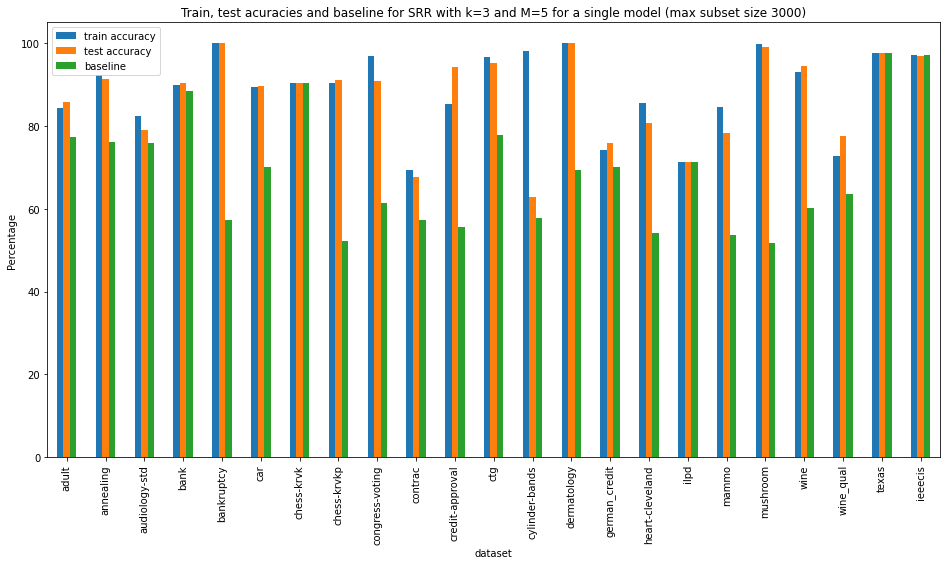

In [5]:
results.plot.bar(x='dataset', figsize=(16, 8), 
                 title='Train, test acuracies and baseline for SRR with k=3 and M=5 for a single model (max subset size 3000)',
                 ylabel='Percentage');